In [1]:
# numpy 18.x and pytables 3.4.x cause error so to use newer numpym pytables should be updated.
import tables
tables.__version__

'3.6.1'

In [36]:
from FPSim2 import FPSim2Engine
from FPSim2 import FPSim2CudaEngine
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import linecache
import cupy as cp
AllChem.SetPreferCoordGen(True)
chemblsmi = 'chembl27.smi'

In [37]:
fpe = FPSim2Engine('chembl27_morgan2_2048.h5')
fpe_cuda = FPSim2CudaEngine('chembl27_morgan2_2048.h5')

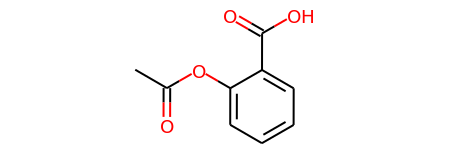

In [38]:
query = 'CC(=O)Oc1ccccc1C(=O)O'
qmol = Chem.MolFromSmiles(query)
qmol

In [39]:
def getmol(index):
    smi = linecache.getline(chemblsmi, index).rstrip()
    #linecache.clearcache()
    return smi

## Sim search with CPU

In [40]:
%time results = fpe.similarity(query, 0.7)
results

CPU times: user 8.44 ms, sys: 19 µs, total: 8.46 ms
Wall time: 7.75 ms


array([(   1116, 1.        ), (1725269, 0.8888889 ),
       ( 234058, 0.85714287), ( 780270, 0.7       )],
      dtype={'names':['mol_id','coeff'], 'formats':['<u4','<f4'], 'offsets':[4,8], 'itemsize':12})

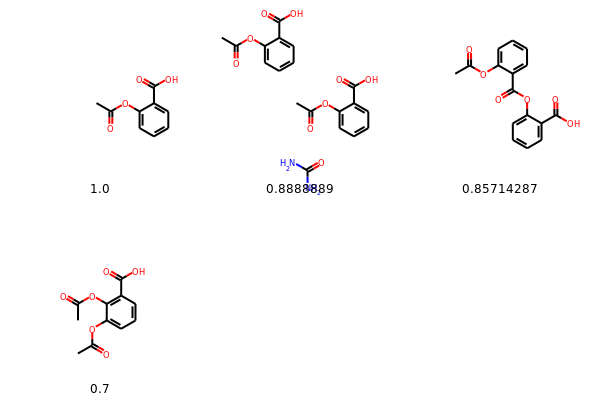

In [42]:
mols = [Chem.MolFromSmiles(getmol(row[0])) for row in results]
tcs = [row[1] for row in results]
Draw.MolsToGridImage(mols, legends=[str(tc) for tc in tcs])

## Sim search with CUDA

In [58]:
%time results = fpe_cuda.similarity(query, 0.8)
results

CPU times: user 6.83 ms, sys: 16.1 ms, total: 22.9 ms
Wall time: 21.9 ms


array([(   1116, 1.        ), (1725269, 0.8888889 ),
       ( 234058, 0.85714287)],
      dtype={'names':['mol_id','coeff'], 'formats':['<u4','<f4'], 'offsets':[4,8], 'itemsize':12})

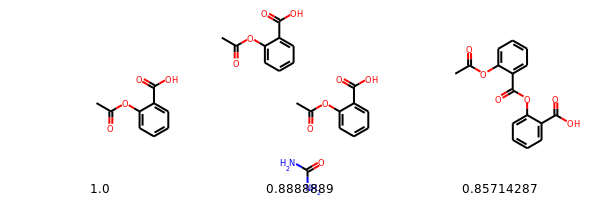

In [46]:
mols = [Chem.MolFromSmiles(getmol(row[0])) for row in results]
tcs = [row[1] for row in results]
Draw.MolsToGridImage(mols, legends=[str(tc) for tc in tcs])

### SS Search with CPU / Cuda engine doesn't have SSS method.
pattern_fpe = FPSim2Engine('chembl27_rdk_pat.h5')

In [66]:
%time results_pat = pattern_fpe.substructure(query)
results_pat.shape

CPU times: user 81.3 ms, sys: 3.68 ms, total: 85 ms
Wall time: 83.8 ms


(8345,)

In [77]:
%time results_pat = pattern_fpe.substructure(query, n_workers=16)
results_pat.shape

CPU times: user 229 ms, sys: 2.45 ms, total: 232 ms
Wall time: 33.2 ms


(8345,)

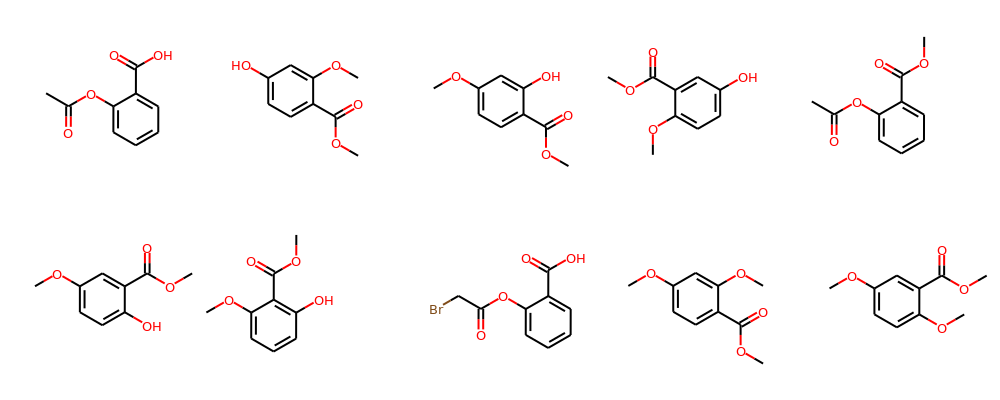

In [67]:
mols = [Chem.MolFromSmiles(getmol(row)) for row in results_pat[:10]]
Draw.MolsToGridImage(mols, molsPerRow=5)

In [75]:
%time results = fpe.substructure(query)
results.shape

CPU times: user 80.1 ms, sys: 0 ns, total: 80.1 ms
Wall time: 78.9 ms


(5,)

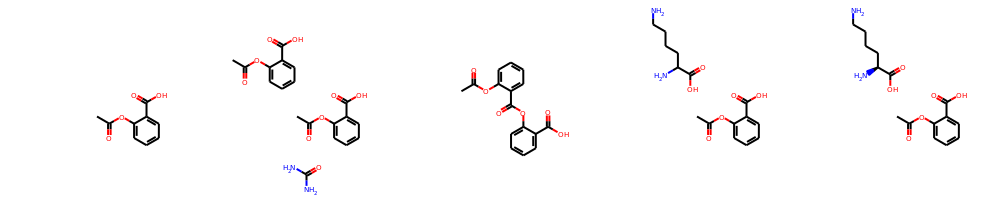

In [70]:
mols = [Chem.MolFromSmiles(getmol(row)) for row in results]
Draw.MolsToGridImage(mols, molsPerRow=5)

In [71]:
import pickle
library = pickle.load(open('chembl27_ssslib.pkl', 'rb'))

In [72]:
%time res = library.GetMatches(qmol)

CPU times: user 544 ms, sys: 0 ns, total: 544 ms
Wall time: 39.9 ms


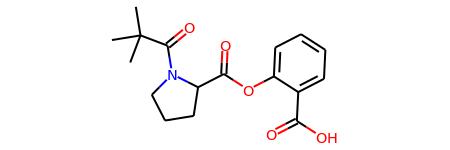

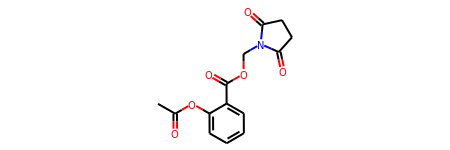

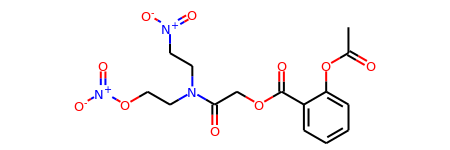

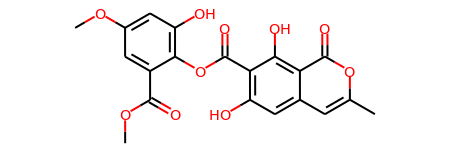

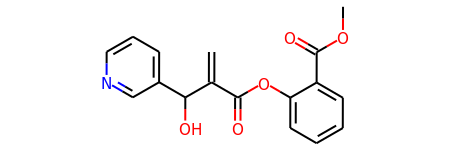

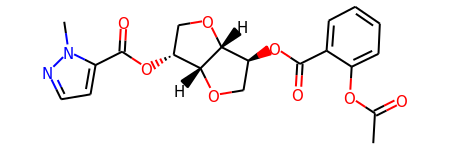

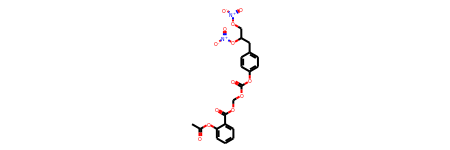

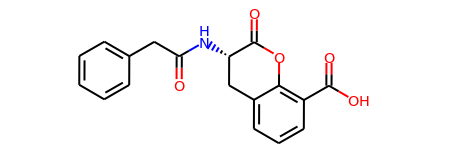

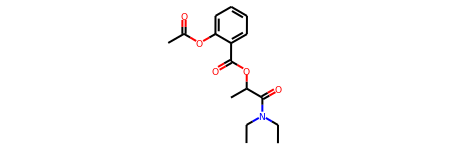

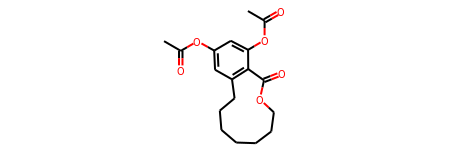

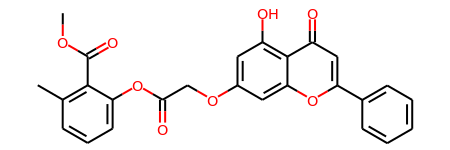

In [73]:
from IPython.display import display
for ind, i in enumerate(res):
    m = library.GetMol(i)
    display(m)
    if ind == 10:
        break